# Bank Customer Segmentation

Customer segmentation is extremely useful for any business. By grouping your customers based on their shared characteristics and behaviors, you can tailor your marketing efforts to suit their needs and preferences.

In this project, we are going to perform customer segmentation for an anonymized real Bank published by Prof. Hofmann.

Notice: This is a mock project but uses real data and therefore is a real-life data science scenario.

Go to this link for the [Project presentation slides](https://docs.google.com/presentation/d/1fmHz-pRrT40Nob2jL2e5lbztW-jkUdPGRbENc-ktmDY/edit?usp=sharing)

>[00 Introducing and preparing the data](#scrollTo=UZEOKdmGA8Ho)

>[01 Exploratory Data Analysis](#scrollTo=lnlT_X96Dont)

>[02 Clustering with KMeans](#scrollTo=Ud5TJRB5aR3C)

>[03 Clustering with Affinity Propagation](#scrollTo=D5Li46VM3O1i)

>[Summary](#scrollTo=oXOhSGhg1x_Q)



In [ ]:
# Importing libraries

import pandas as pd #(essential to manipualte data frames in python)
import numpy as np #(prividing linear algebra)
import seaborn as sns #(nice visualizations)
import matplotlib.pyplot as plt #(basic tools for viz)
from sklearn.preprocessing import StandardScaler #(machine learning libraries)
from sklearn.cluster import KMeans, AffinityPropagation #(machine learning libraries)
#import warnings
#warnings.filterwarnings("ignore")

# 00 Introducing and preparing the data

In [ ]:
data = pd.read_csv("/content/german_credit_data.csv", index_col=0)

data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car




`customer_segmentation.csv`: demographics and credit data of the bank's clients;  1,000 persons (rows) x 10 features.
* Age (numeric)
* Sex (text: `male`, `female`)
* Job (numeric: `0` - unskilled and non-resident, `1` - * unskilled and resident, `2` - skilled,`3` - highly skilled)
* Housing (text: `own`, `rent`, or `free`)
* Saving accounts (text - `little`, `moderate`, `quite rich`, `rich`)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: `car`, `furniture/equipment`, `radio/TV`, `domestic appliances`, `repairs`, `education, business`, `vacation/others`)



Let's now check that the data documentation is aligned with the actual dataset.

In [ ]:
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("Columns data types:\n{}".format(data.dtypes))

Database has 1000 obserwations (customers) and 9 columns (attributes).
Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


In [ ]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


Indeed, all fields, their types, and unique values match with the documentation.

There are some missing values for `Saving accounts` and `Checking account`, but those are probably from customers that don't have those in our bank.

# 01 Exploratory Data Analysis

Let's visualize plots for different numeric variables.






In [ ]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,6))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

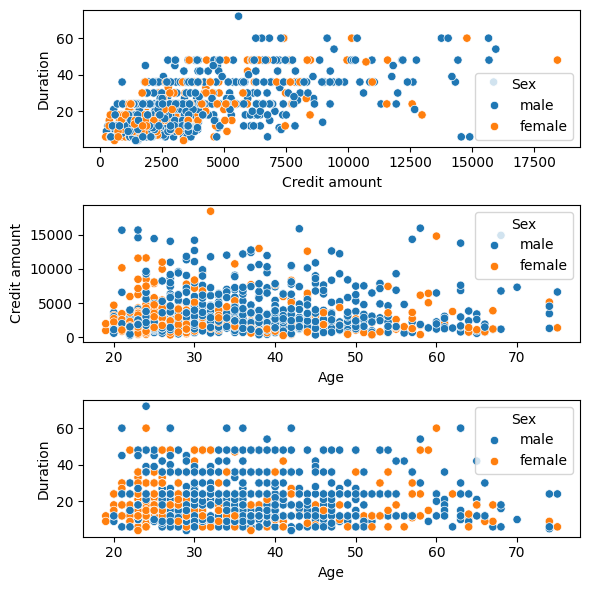

In [ ]:
scatters(data, h="Sex")

There are not many strong conclusions to draw from these graphs. It seems that women tend to take credits younger than men.

Also, it looks like there is a correlation between the Credit amount and the Duration of the credit. Which makes sense.

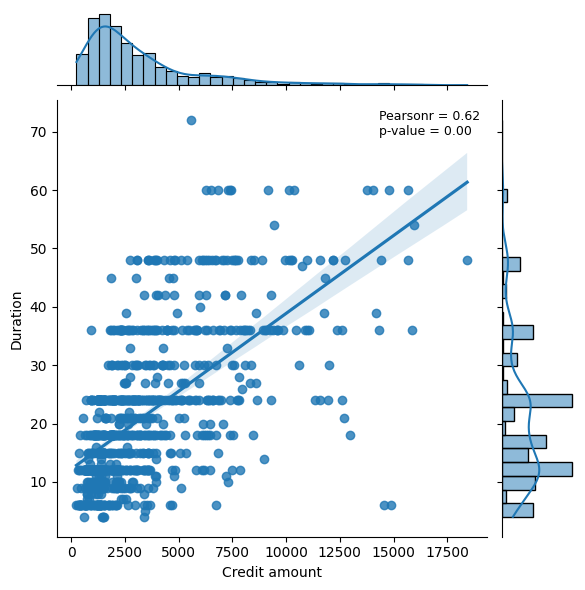

In [ ]:
import scipy.stats as stats
# Create the jointplot
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=6)

# Calculate Pearson correlation coefficient and p-value
pearson_coef, p_value = stats.pearsonr(data["Credit amount"], data["Duration"])

# Annotate the plot with correlation coefficient and p-value
r1.ax_joint.annotate(f"Pearsonr = {pearson_coef:.2f}\np-value = {p_value:.2f}", xy=(0.75, 0.92), xycoords='axes fraction', fontsize=9)

plt.show()

No surprise here. The plot shows a Pearson correlation of 0.62, which was expected since larger credits need longer durations.

Let's check by sex:

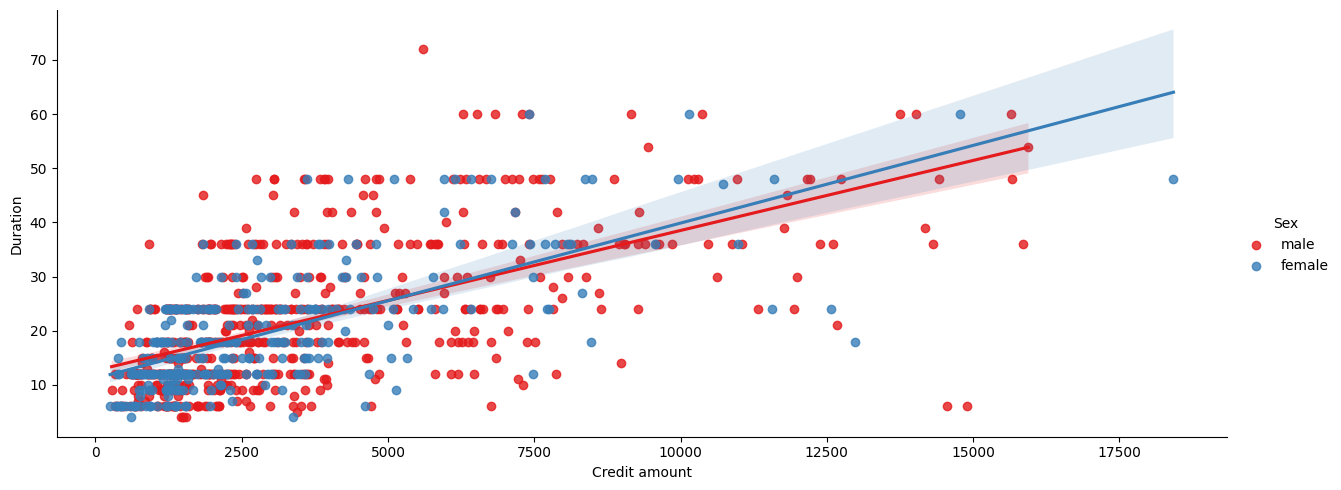

In [ ]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2.5)
plt.show()

No big differences, but we can see that men take slightly larger credits and therefore longer durations.

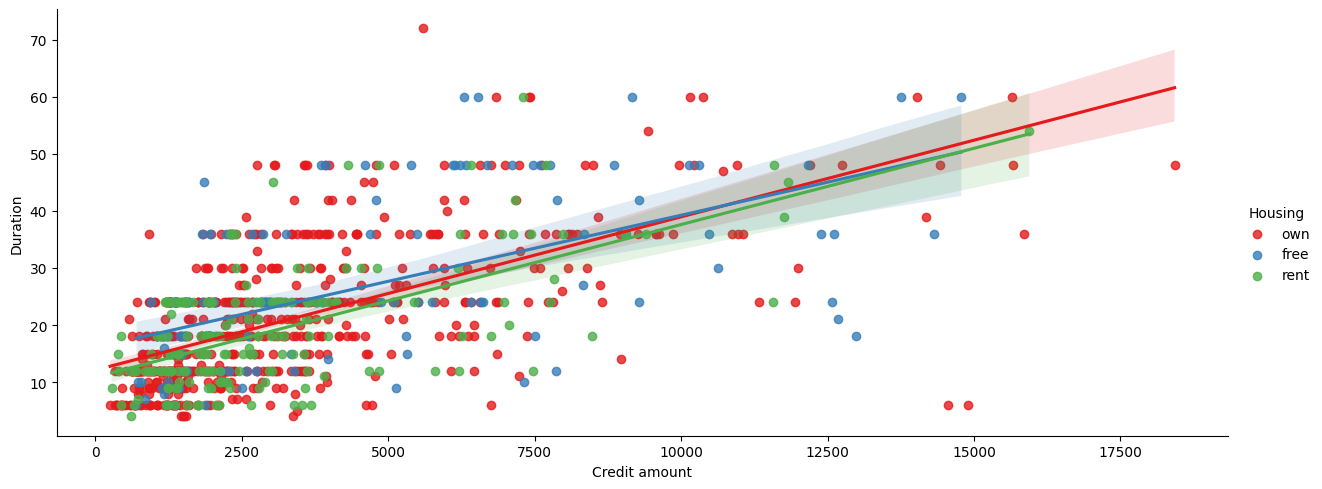

In [ ]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2.5)
plt.show()

Well, no real differences between housing categories.

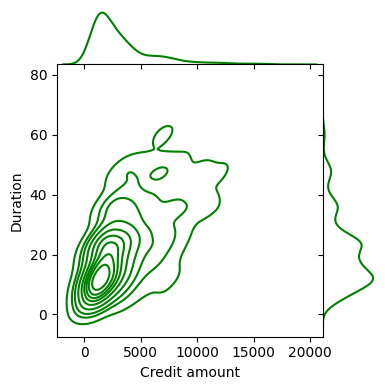

In [ ]:
sns.jointplot(x=data["Credit amount"], y=data["Duration"], kind="kde", space=0, color="g", height=4)

plt.show()


<ipython-input-9-8edb59cb18ad>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar.set_xticklabels(n_credits["Purpose"], rotation=30)


,Purpose,Count
1,car,337
5,radio/TV,280
4,furniture/equipment,181
0,business,97
3,education,59
6,repairs,22
2,domestic appliances,12
7,vacation/others,12


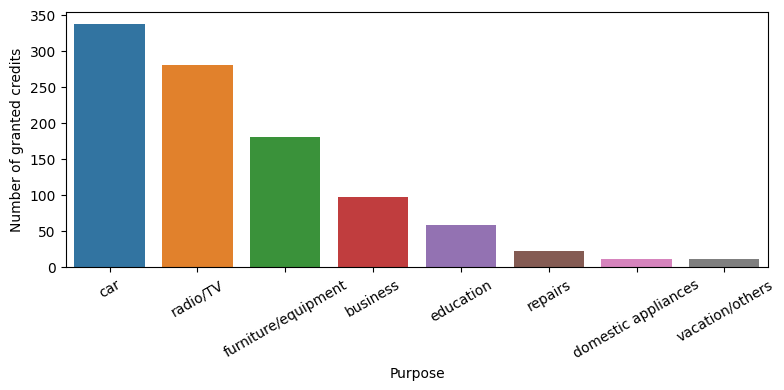

In [ ]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(8,4))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits, hue='Purpose', legend=False)
bar.set_xticklabels(n_credits["Purpose"], rotation=30)
plt.ylabel("Number of granted credits")
plt.tight_layout()
n_credits


The graph above shows that most of the credits were given to cars and radio/TV

Let's generate now boxplots to study each in more detail.

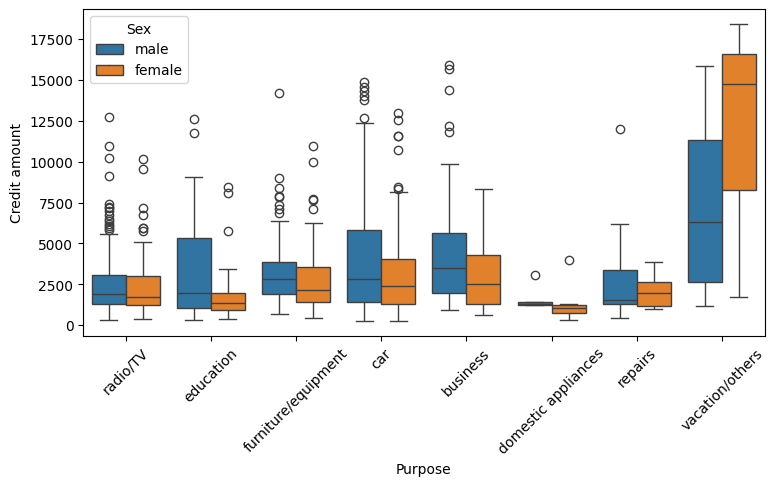

In [ ]:
def boxes(x,y,h, r=45):
  fig, ax = plt.subplots(figsize=(8,4))
  box = sns.boxplot(x=x, y=y, hue=h, data=data)
  fig.subplots_adjust(bottom=0.2)
  plt.tight_layout()
  plt.xticks(rotation=r)

boxes("Purpose", "Credit amount", "Sex")

This set of box plots still offers us no huge differences in sex. We can see that most of the outliers are on the upper side.

And that the smallest credits were given in the domestic appliances category while the biggest ones came from the vacation/others category. However, we should remember that the number of credits in this category was rather small (12 samples) compared, for example, to cars(337) or radio/TV (280)

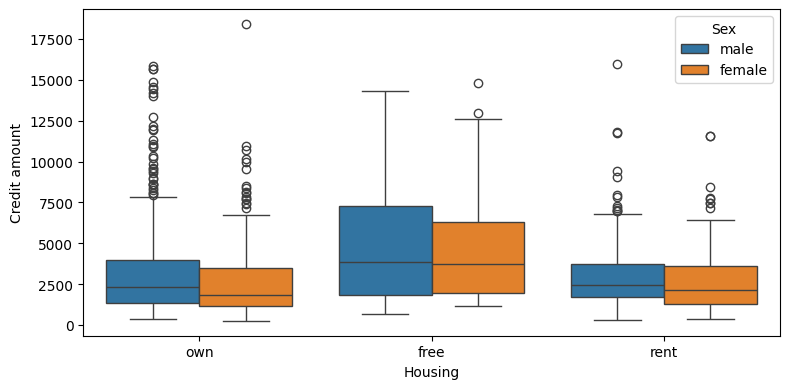

In [ ]:
boxes("Housing","Credit amount","Sex",r=0)

In this set, we can clearly see that those who don't pay for their housing tend to get slightly bigger credits.

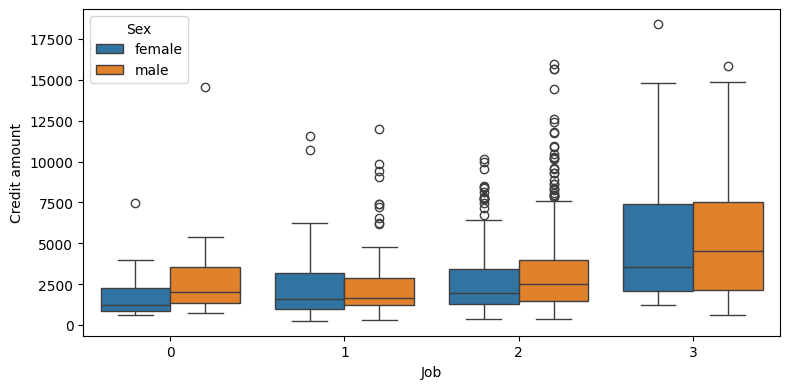

In [ ]:
boxes("Job","Credit amount","Sex",r=0)

Again, we can see how the highly skilled workers get larger credits from the bank. And, also again, no real differences between genders.

We remind you of the categories: `0` - unskilled and non-resident, `1` - * unskilled and resident, `2` - skilled,`3` - highly skilled


#02 Clustering with KMeans


Here is when the real customer segmentation begins.

For clustering, we need to create a data frame only with the numerical variables (Age, Credit amount, Duration).



In [ ]:
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]



Let's do a function to create histograms easily for each variable.

In [ ]:
def histo(df):
 fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,6))
 sns.histplot(df["Age"], ax=ax1)
 sns.histplot(df["Credit amount"], ax=ax2)
 sns.histplot(df["Duration"], ax=ax3)
 plt.tight_layout()

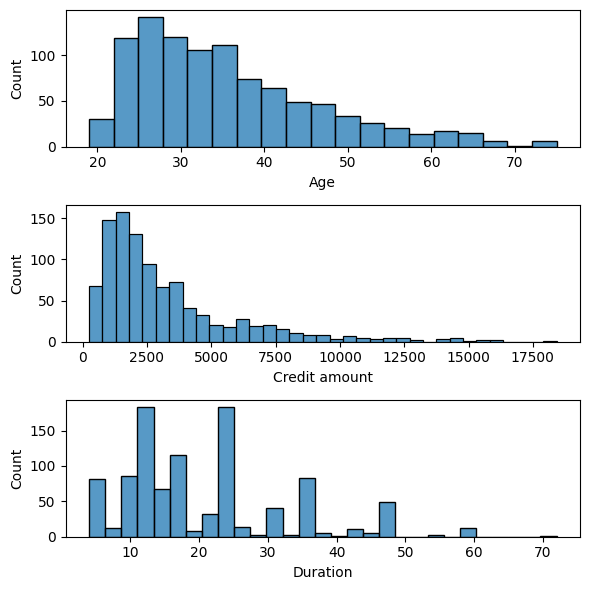

In [ ]:
histo(cluster_data)

We can see that distributions are accumulated on the left. To obtain better results we should remove the skewness by logarithmic transformation.




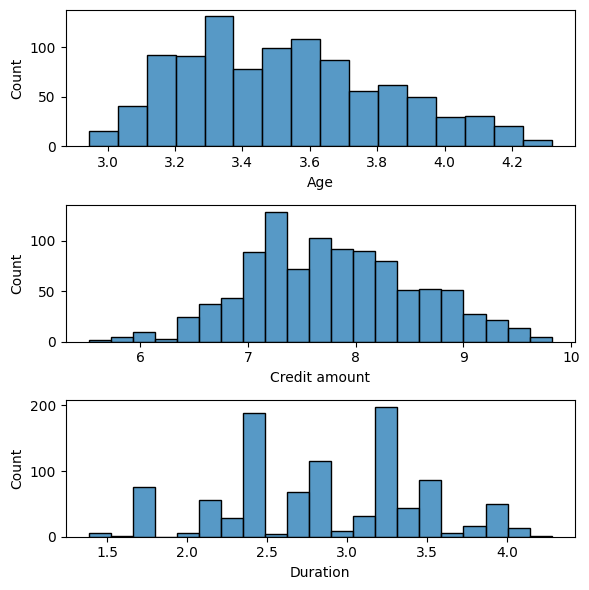

In [ ]:
cluster_log = np.log(cluster_data)
histo(cluster_log)

The skewness is gone!

Now we need to center and scale our variables. This is required by KMeans algorithm.

But do not worry, the sklearn library has the StandardScaler function just for that!

In [ ]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

Now we need to find out what is the perfect number of clusters for our group.

We will do this by checking the **inertia** for various numbers.

The inertia metric indicates the dispersion of points within a cluster, reflecting the cluster's homogeneity. If there are too many clusters, the inertia tends to decrease, resulting in highly homogeneous groups. Conversely, if there are too few clusters, the inertia increases, indicating insufficient homogeneity and rendering our customer segmentation inaccurate.



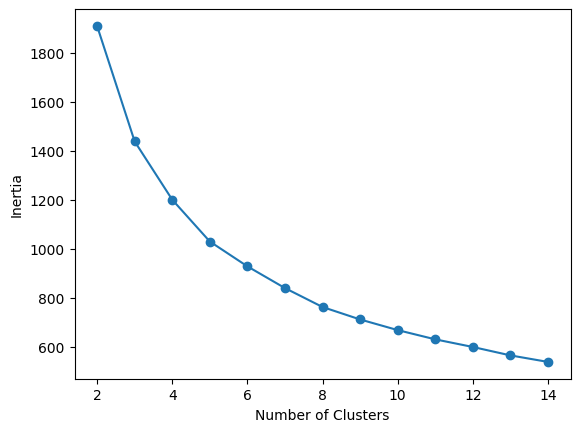

In [ ]:
clusters_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
inertias = []

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0, n_init=10).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.show()



Let's perform this analysis with different seeds.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

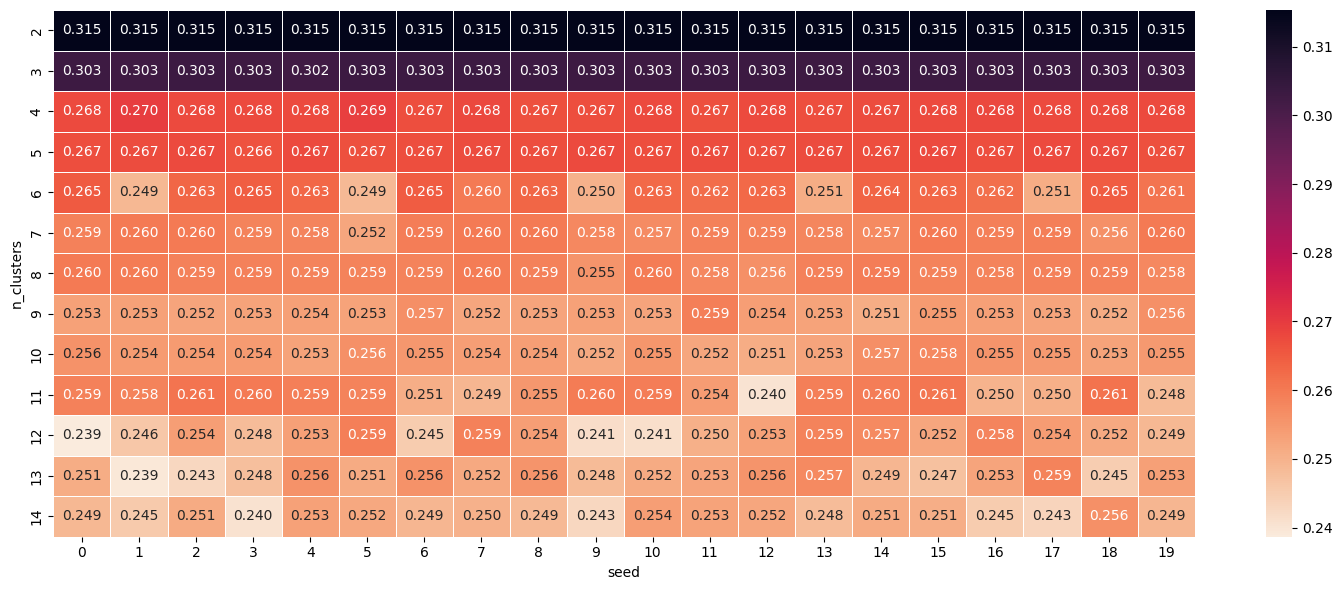

In [ ]:
clusters_range=range(2,15)
random_range = range(0,20)
results = []

for c in clusters_range:
  for r in random_range:
    clusterer= KMeans(n_clusters=c, random_state=r, n_init=10)
    cluster_labels = clusterer.fit_predict(cluster_scaled)
    silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
    results.append([c,r,silhouette_avg])

result= pd.DataFrame(results, columns=["n_clusters", "seed", "silhouette_score"])
pivot_km = pd.pivot_table(result, index= "n_clusters", columns= "seed", values="silhouette_score")


plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=0.5, fmt=".3f", cmap=sns.cm.rocket_r)
plt.tight_layout()


This heatmap shows the silhouette scores for every scenario where the number of clusters goes from 14 to 2. But then randomizes the centers of each cluster 20 times.

This silhouette score goes from -1 to 1. 1 being clusters perfecly separated and points from each cluster extremely closer to each other.

As we can see, the most differentiate clusters ocurr when we have 2 or 3 clusters.

For this analysis, I am going to for 3 clusters to get more insight into the data.



In [ ]:
kmeans_sel = KMeans(n_clusters=3, random_state=1, n_init=10).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

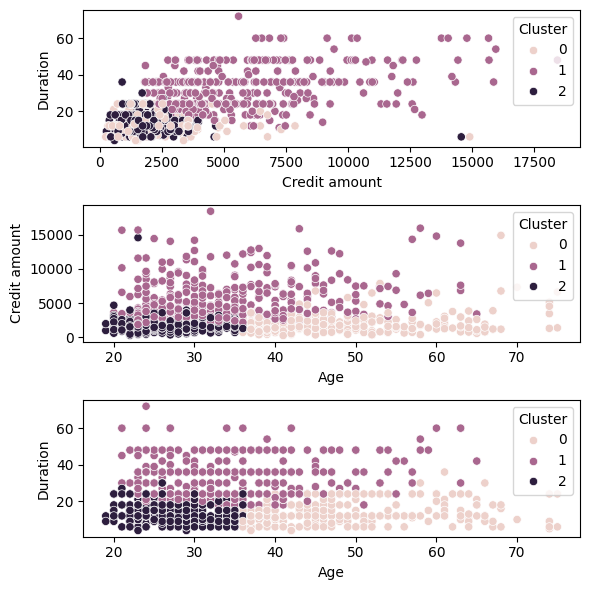

In [ ]:
scatters(clustered_data, 'Cluster')

These plots show our three clusters.

- 0 and 2 are small amounts for older and younger clients, respectively.
- 1 is a cross-age group with larger credits.

Let's explore these clusters further.

In [ ]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


# 03 Clustering with Affinity Propagation

Now, we will try a different clustering process.

In this case, the algorithm itself will choose the number of clusters.

To do that, we need to set the `preference` parameter

A higher preference value, tending towards zero or positive, increases the likelihood of data points becoming exemplars, thereby resulting in a greater number of clusters. On the other side, a lower preference value, more negative in nature, decreases the likelihood of data points becoming exemplars, thereby yielding fewer clusters.

In fact, we are going to test the algorithm against many different parameter values.


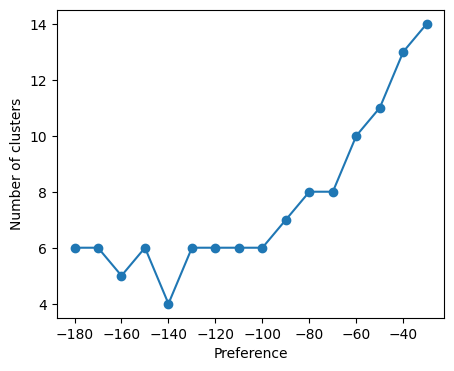

In [ ]:
#We are going to try from preference -30 to -190 in intervals of -10
preferences = np.arange(-30,-190,-10)
#creating empty list
clusters = []
#loop to calculate the number of clusters (len) for each instance of p (preference)
for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

#Graph
plt.figure(figsize=(5,4))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

This plot shows The algorithm has detected that a preference of -140 produces 4 clusters, which is most likely the most optimal solution where the data points are grouped into more distinct categories.

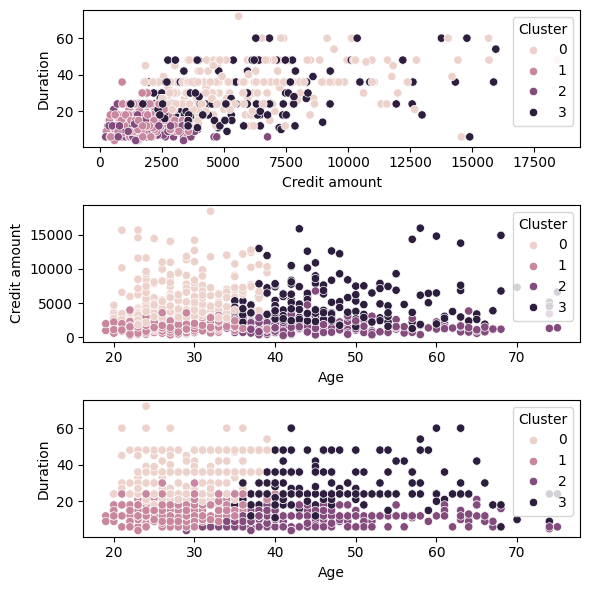

In [ ]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af =pd.DataFrame(af.labels_)
n_clusters = len(af.cluster_centers_indices_)
clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af, 'Cluster')
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

As we can see, this Affinity algorithm has identified four different customer clusters.

Cluster 0 – Big, long credits. Young

Cluster 1 – small, short credits. Young

Cluster 2 - small, short credits. Older

Cluster 3 - Big, long credits. Older.

Let's explore how different these four personas are:

In [ ]:
#Merging the column Clusters to our initial data frame.
merged_data_af = pd.merge(clustered_data_af, data, how='inner', on=["Age", "Credit amount", "Duration"]).fillna("No")

#Substitute NaN values for "No"
merged_data_af

,Age,Credit amount,Duration,Cluster,Sex,Job,Housing,Saving accounts,Checking account,Purpose
0,67,1169,6,2,male,2,own,No,little,radio/TV
1,22,5951,48,0,female,2,own,little,moderate,radio/TV
2,49,2096,12,2,male,1,own,little,No,education
3,45,7882,42,3,male,2,free,little,little,furniture/equipment
4,53,4870,24,3,male,2,free,little,little,car
...,...,...,...,...,...,...,...,...,...,...
995,31,1736,12,1,female,1,own,little,No,furniture/equipment
996,40,3857,30,3,male,3,own,little,little,car
997,38,804,12,2,male,2,own,little,No,radio/TV
998,23,1845,45,0,male,2,free,little,little,radio/TV


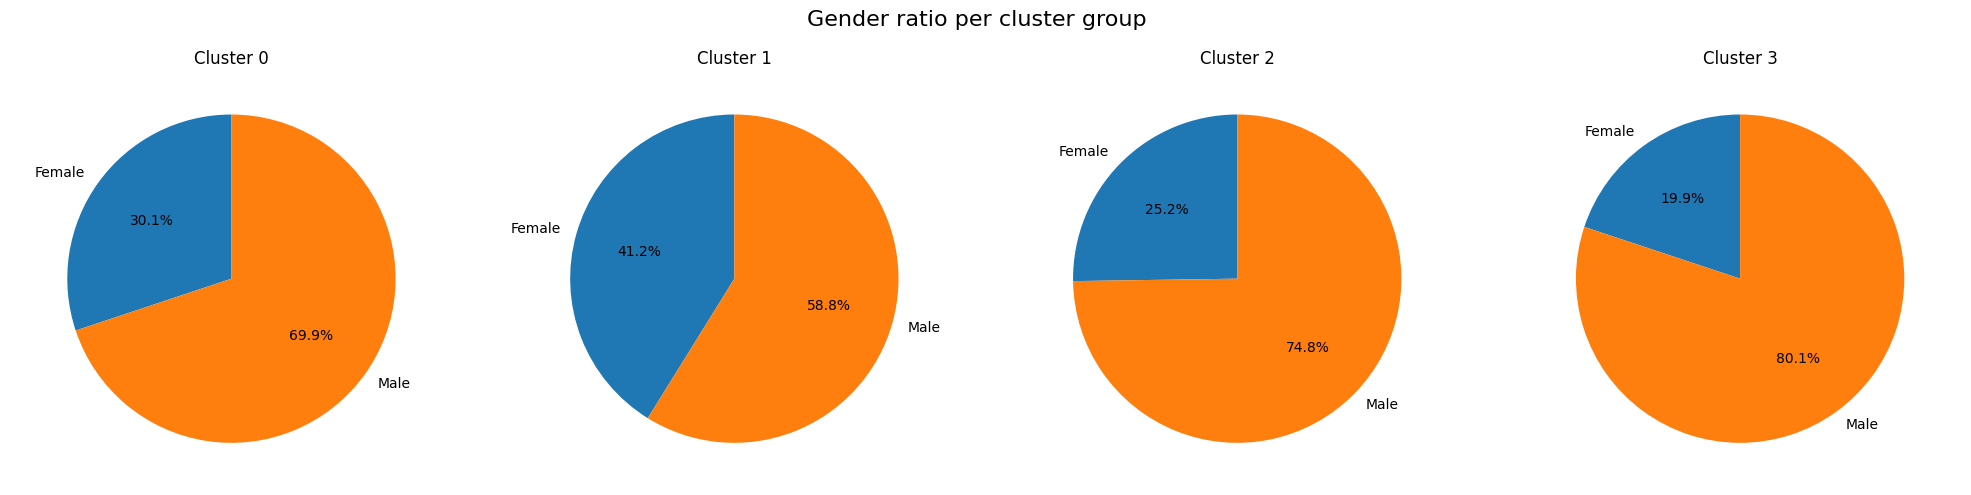

In [ ]:
merged_data_af.groupby(['Cluster', 'Sex']).size()

# Pivot the DataFrame
pivot_sex = pd.pivot_table(merged_data_af, index='Cluster', columns='Sex', aggfunc='size', fill_value=0)
pivot_sex.columns = ['Female', 'Male']

# Set up the subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Gender ratio per cluster group', fontsize=16)


# Iterate over each cluster and create a pie chart
for i, cluster in enumerate(pivot_sex.index):
    # Extract data for the current cluster
    female_count = pivot_sex.loc[cluster, 'Female']
    male_count = pivot_sex.loc[cluster, 'Male']

    # Plot pie chart
    axes[i].pie([female_count, male_count], labels=['Female', 'Male'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



There are no big differences within the clusters when it comes to the gender ratio.

In every instance, men are more common, especially in the cluster 3 (Big, long credits, older customers). But more frequent than average in cluster 1 (small, short credits. Younger customers)

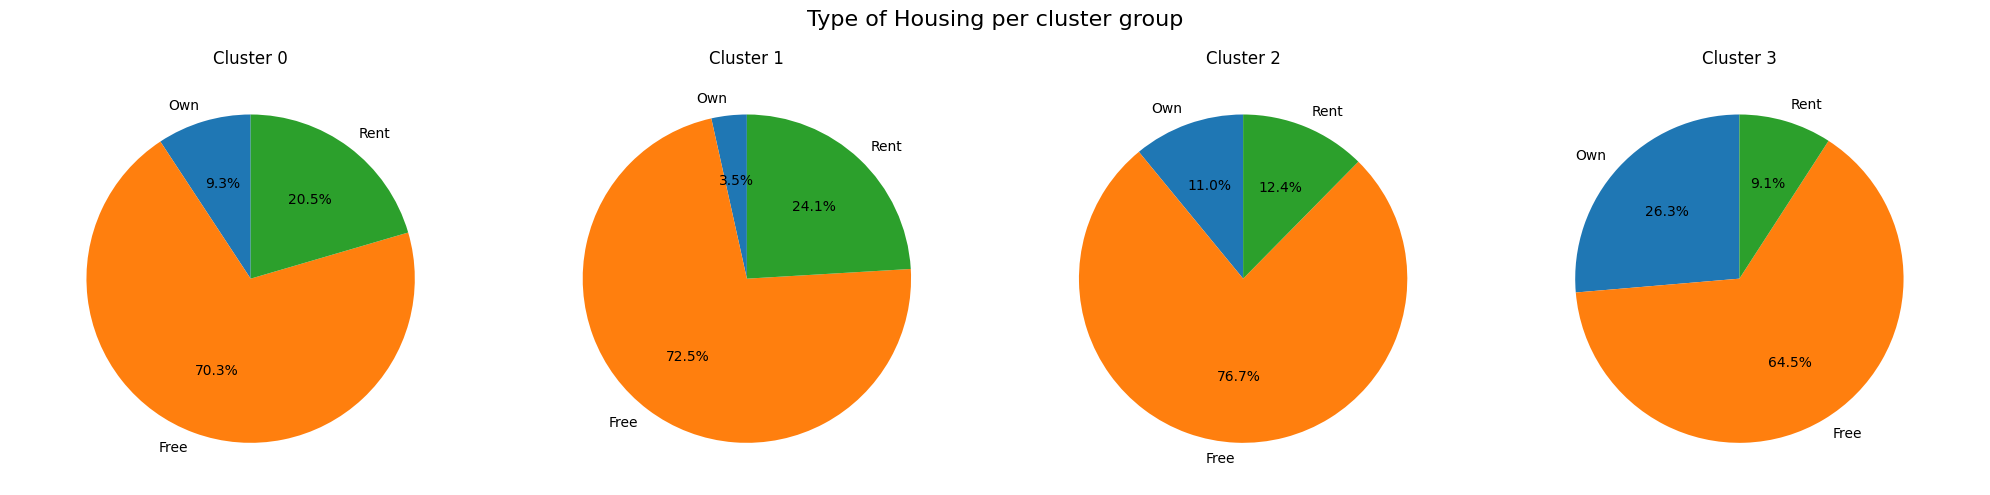

In [ ]:
merged_data_af.groupby(['Cluster', 'Housing']).size()

# Pivot the DataFrame
pivot_house = pd.pivot_table(merged_data_af, index='Cluster', columns='Housing', aggfunc='size', fill_value=0)
pivot_house.columns = ['Own', 'Free', 'Rent']

# Set up the subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Type of Housing per cluster group', fontsize=16)


# Iterate over each cluster and create a pie chart
for i, cluster in enumerate(pivot_house.index):
    # Extract data for the current cluster
    Own_count = pivot_house.loc[cluster, 'Own']
    Free_count = pivot_house.loc[cluster, 'Free']
    Rent_count = pivot_house.loc[cluster, 'Rent']
    # Plot pie chart
    axes[i].pie([Own_count, Free_count, Rent_count], labels=['Own', 'Free', 'Rent'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Again there are no big differences among the clusters. Free housing is the most prevalent for all of them.

And one more time, we find Cluster 1 and 3 showing unique characteristics.

Cluster 1 is renting more often and Cluster 3 owns their houses.

```
# This is formatted as code
```





In [ ]:
data["Job"].unique()

array([2, 1, 3, 0])

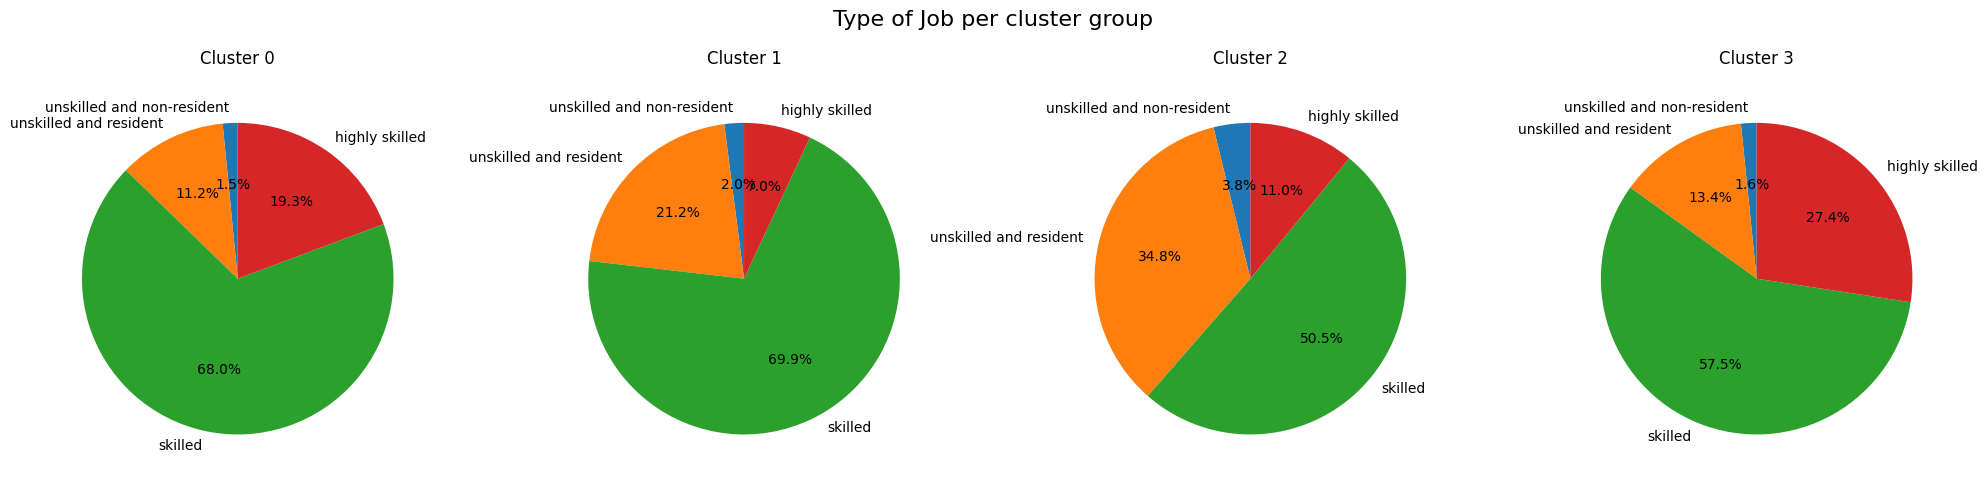

In [ ]:

# Pivot the DataFrame
pivot_df = pd.pivot_table(merged_data_af, index='Cluster', columns='Job', aggfunc='size', fill_value=0)
pivot_df.columns = pivot_df.columns.astype(str)

# Set up the subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Type of Job per cluster group', fontsize=16)


# Iterate over each cluster and create a pie chart
for i, cluster in enumerate(pivot_df.index):
    # Extract data for the current cluster
    count_unskilledno = pivot_df.loc[cluster, '0']
    count_unskilled = pivot_df.loc[cluster, '1']
    count_skilled = pivot_df.loc[cluster, '2']
    count_high = pivot_df.loc[cluster, '3']

    # Plot pie chart
    axes[i].pie([count_unskilledno, count_unskilled, count_skilled, count_high],
                labels=(["unskilled and non-resident","unskilled and resident","skilled","highly skilled"]),
                autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In the Job case, the most common customer is a skilled worker in all clusters. With a brief exception in cluster 2 (small, short credits. Older customers), where more unskilled workers appear.

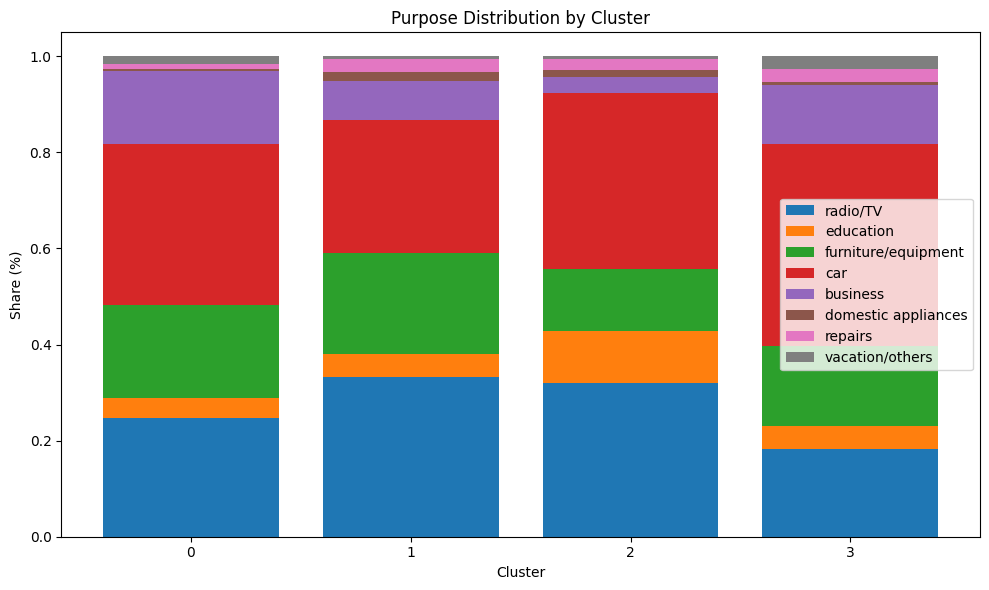

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pivot the DataFrame
pivot_df = pd.pivot_table(merged_data_af, index='Cluster', columns='Purpose', aggfunc='size', fill_value=0)
pivot_df.columns = pivot_df.columns.astype(str)

# Calculate the total count of each cluster
total_counts = pivot_df.sum(axis=1)

# Normalize counts to get shares (as percentages)
normalized_df = pivot_df.div(total_counts, axis=0)

# Initialize a list to store the bottom position of each bar
bottom = np.zeros(len(pivot_df))

# Plot the bar chart
plt.figure(figsize=(10, 6))
for i, purpose in enumerate(purposes):
    shares = normalized_df[purpose]
    plt.bar(normalized_df.index, shares, bottom=bottom, label=purpose)
    bottom += shares

plt.xlabel('Cluster')
plt.ylabel('Share (%)')
plt.title('Purpose Distribution by Cluster')
plt.xticks(normalized_df.index)
plt.legend()
plt.tight_layout()
plt.show()


No relevant differences regarding the purpose of the credit.

In [ ]:
pivot_df

Saving accounts,No,little,moderate,quite rich,rich
Cluster,,,,,
0,50,147,34,17,11
1,47,224,37,18,19
2,37,125,17,19,12
3,49,107,15,9,6


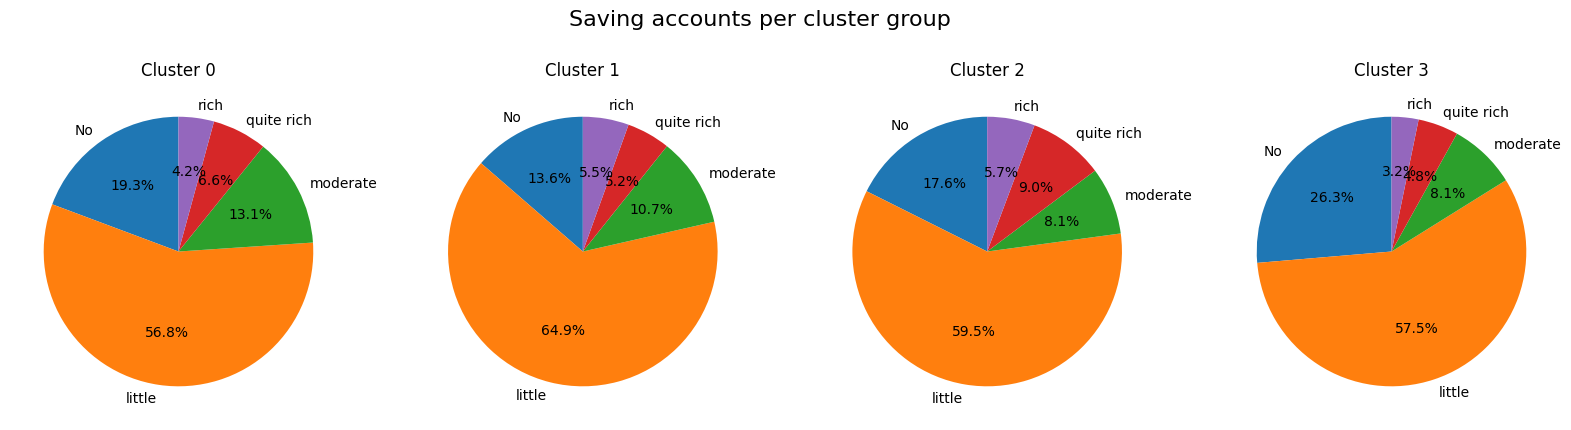

In [ ]:
# Pivot the DataFrame
pivot_df = pd.pivot_table(merged_data_af, index='Cluster', columns='Saving accounts', aggfunc='size', fill_value=0)

# Set up the subplots dynamically based on the number of clusters
fig, axes = plt.subplots(1,4, figsize=(20, 5))
fig.suptitle('Saving accounts per cluster group', fontsize=16)


# Iterate over each cluster and create a pie chart
for i, (cluster, data) in enumerate(pivot_df.iterrows()):
    # Extract data for the current cluster
    categories = data.index
    counts = data.values

    # Plot pie chart
    axes[i].pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster}')

# Adjust layout to prevent overlap
plt.show()

Those customers with little or no savings reign in all clusters. There are no major differences to write down for our personas.

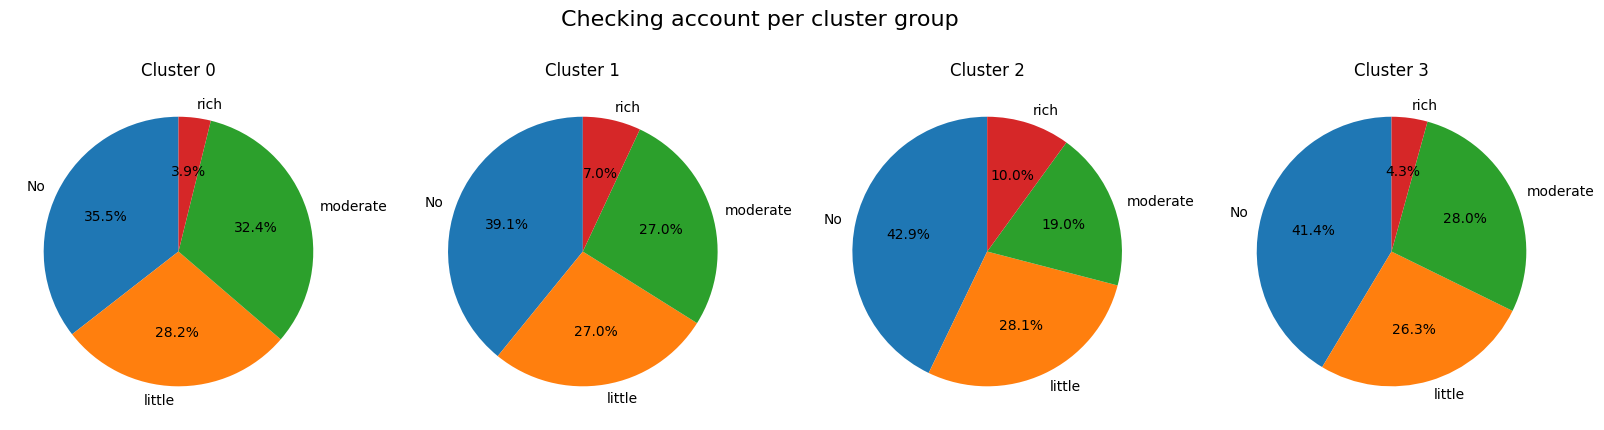

In [ ]:
# Pivot the DataFrame
pivot_df = pd.pivot_table(merged_data_af, index='Cluster', columns='Checking account', aggfunc='size', fill_value=0)

# Set up the subplots dynamically based on the number of clusters
fig, axes = plt.subplots(1,4, figsize=(20, 5))
fig.suptitle('Checking account per cluster group', fontsize=16)


# Iterate over each cluster and create a pie chart
for i, (cluster, data) in enumerate(pivot_df.iterrows()):
    # Extract data for the current cluster
    categories = data.index
    counts = data.values

    # Plot pie chart
    axes[i].pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster}')

# Adjust layout to prevent overlap
plt.show()

In this case, again, the differences are too small to have a significant impact on our main marketing targets.

# Summary

In this Data project, we analyzed customer data from a German bank to better understand which kind of personas are obtaining credits from them.

We used two different algorithms to determine the number of clusters based on the customers' age, the amount of the credit, and the duration of it.

Using these three variables, we determined that there are 4 personas. Then we carried out some variable analyses


Cluster | Age (avg) | Amount (avg) | Duration | Housing | Job | Savings | Account | Purpose | Sex (% Male) |
-|  --- | --- | --- | --- | --- | --- | | | |
0| Young (28.7) | Big (5593.7) |Long (32.2)| Free ~rent  |Skilled ~Highly     | Little or No | No to Moderate | Heterogeneous | Male (69.9%)
1| Young (27.9) | Small (1654.3)|Short (15.1)| Free ~rent| Skilled            | Little       | No to Moderate | Heterogeneous | Male (58.8%)
2| Older (46.0) | Small (1551.7)|Short (10.7)| Free      | Skilled & unskilled| Little or No | No to Moderate | Heterogeneous | Male (74.8%)
3| Older (47.5) | Big (4977.9) |Long (27.6)| Free ~Own   | Skilled ~Highly    | Little or No | No to Moderate | Heterogeneous | Male (80.1%)
~Not so prevalent


Check the Project Slides [here](https://docs.google.com/presentation/d/1fmHz-pRrT40Nob2jL2e5lbztW-jkUdPGRbENc-ktmDY/edit#slide=id.p).